In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')

In [90]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

from ast import literal_eval

Testing py files

In [91]:
# %load_ext autoreload
# %autoreload 2

# from src.recommender import *
# from src.run import *

In [92]:
requests_df = pd.read_csv('data/requests.csv')
requests_df.head()

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


In [93]:
# requests_df.groupby('user').count().sort_values('movie')

In [94]:
training = pd.read_csv('data/training.csv')
training.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [95]:
training.groupby('user').count().sort_values('movie')

,movie,rating,timestamp
user,,,
3326,2,2,2
3038,2,2,2
4273,3,3,3
3288,3,3,3
1779,4,4,4
...,...,...,...
3618,1344,1344,1344
4277,1407,1407,1407
4169,1440,1440,1440


In [96]:
training['movie'].nunique()

3662

In [97]:
# Setup a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [98]:
# Convert a Pandas DF to a Spark DF
spark_df = spark.createDataFrame(training) 
spark_df.printSchema()

root
 |-- user: long (nullable = true)
 |-- movie: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- timestamp: long (nullable = true)



In [50]:
spark_df = spark_df.drop('timestamp')
spark_df.show(5)

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|6040|  858|     4|
|6040|  593|     5|
|6040| 2384|     4|
|6040| 1961|     4|
|6040| 2019|     5|
+----+-----+------+
only showing top 5 rows



In [99]:
train, validation = spark_df.randomSplit([0.8, 0.2], seed=111)

In [45]:
num_users = train.select('user').distinct().count()
num_movies = train.select('movie').distinct().count()
density = train.count() / (num_users*num_movies)
density

0.032597051957118636

In [51]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
)

In [100]:
# Get predictions on all data
recommender = als_model.fit(train)
predictions = recommender.transform(train)
predictions.show(5)

+----+-----+------+---------+----------+
|user|movie|rating|timestamp|prediction|
+----+-----+------+---------+----------+
|4227|  148|     2|965659724| 2.1314542|
|3184|  148|     4|968708953|  3.108513|
|2383|  148|     2|974417654|   2.33238|
|1242|  148|     3|974909976|  2.651939|
|1069|  148|     2|974945135| 2.2072148|
+----+-----+------+---------+----------+
only showing top 5 rows



In [28]:
#predictions.describe().show()
#user1 = recommender.recommendForUserSubset(predictions, 10).where('user==700').select('recommendations').take(1)

+-------+------------------+------------------+-----------------+------------------+
|summary|              user|             movie|           rating|        prediction|
+-------+------------------+------------------+-----------------+------------------+
|  count|            640609|            640609|           640609|            640609|
|   mean|3401.1176411820625|1849.4385124155297|3.589540577793943|  3.43392683692284|
| stddev| 1546.400915028185|  1086.89519415766|1.120587654104148|0.6736404831867843|
|    min|               636|                 1|                1|        0.36868173|
|    max|              6040|              3952|                5|         5.4655166|
+-------+------------------+------------------+-----------------+------------------+



In [127]:
user_factors_df = recommender.userFactors.toPandas()
movie_factors_df = recommender.itemFactors.toPandas()

user_factors_df = user_factors_df.set_index('id')
movie_factors_df = movie_factors_df.set_index('id')

# user_factors_df.to_csv('data/user_factors_all.csv')
# movie_factors_df.to_csv('data/movie_factors_all.csv')

In [129]:
np.array(user_factors_df.loc[4958, 'features'])
user_factors_df

,features
id,
640,"[1.3345701694488525, 0.0006856442778371274, 0...."
650,"[1.1257870197296143, 0.5433434844017029, 0.148..."
660,"[0.5552825331687927, 0.7889283299446106, 0.486..."
670,"[1.0764297246932983, 0.9754031896591187, 0.586..."
680,"[0.8031525015830994, 1.045031189918518, 0.0653..."
...,...
5999,"[0.04606025293469429, 1.0087627172470093, 1.30..."
6009,"[0.4911828637123108, 0.6469261646270752, 0.441..."
6019,"[0.7893272042274475, 0.4643000662326813, 0.697..."


## Read in saved user and movie factors
training data only: user_factors and movie_factors

all data: user_factors_all, movie_factors_all

In [130]:
# user_factors_df = pd.read_csv('data/user_factors_all.csv', index_col='id')
# movie_factors_df = pd.read_csv('data/movie_factors_all.csv', index_col='id')

In [154]:
def predicted_rating(df_user, df_movies, user_id, movie_id):
    try:
        # Get features from df and turn from string into list
        user = np.array(df_user.loc[user_id, 'features'])
    except:
        user = find_similar_users(user_id)
 
    try:
        item = np.array(df_movies.loc[movie_id, 'features'])
    except:
        item = find_similar_items(movie_id)

        
    if user.shape == item.shape:
        return np.dot(np.array(user), np.array(item))
    else:
        return -1    
    
def find_similar_users(user_id):
    return np.array(-1)
    
def find_similar_items(movie_id):
    return np.array(1)

In [155]:
def out_of_bounds(df):
    df.loc[df['ratings']<1, 'rating'] = 1
    df.loc[df['ratings']>5, 'rating'] = 5
    return df

In [156]:
# Checking the function vs import from the csv. 
# Note that rerunning the model changes the latent features, which then changes the predicted rating. 

# print(predicted_rating(4958, 1924))
u = (user_factors_df.loc[4958, 'features'])
m = (movie_factors_df.loc[1924, 'features'])

u2 = recommender.userFactors.where('id == 4958').collect()[0]['features']
m2 = recommender.itemFactors.where('id == 1924').collect()[0]['features']

print(np.dot(np.array(u), np.array(m)))
predicted_rating(user_factors_df, movie_factors_df,4958, 1924)

2.824400122251891


2.824400122251891

In [157]:
u2 = recommender.userFactors.where('id == 4958').collect()[0]['features']
m2 = recommender.itemFactors.where('id == 1924').collect()[0]['features']
u2, m2

([0.422880619764328,
  0.5247925519943237,
  0.7196755409240723,
  1.0763497352600098,
  0.9443488121032715,
  0.02531580440700054,
  1.5075629949569702,
  0.18336190283298492,
  0.48639869689941406,
  0.43761566281318665],
 [0.41337838768959045,
  0.3159404397010803,
  1.1054400205612183,
  0.012045172974467278,
  0.0,
  0.0,
  1.0892760753631592,
  0.18058253824710846,
  0.0,
  0.0])

In [158]:
test_request = requests_df.copy()
test_request.head()

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


In [159]:
# Get predicted ratings
test_request['rating'] = test_request.apply(lambda x: predicted_rating(user_factors_df,
                                                                       movie_factors_df,
                                                                       x['user'], 
                                                                       x['movie']), axis=1)

In [160]:
test_request

,user,movie,rating
0,4958,1924,2.824400
1,4958,3264,2.922105
2,4958,2634,3.015310
3,4958,1407,3.013730
4,4958,2399,2.286675
...,...,...,...
200204,1875,3793,3.205769
200205,1875,2160,3.340235
200206,1875,1035,3.972293
200207,1875,1580,3.317187


In [85]:
# Fix out of bounds ratings
test_request.loc[test_request['rating']<1, 'rating'] = 1
test_request.loc[test_request['rating']>5, 'rating'] = 5

1.000000    95835
1.695428        4
2.793256        1
3.585429        1
3.637921        1
            ...  
3.754011        1
3.237545        1
3.981824        1
3.499878        1
3.014525        1
Name: rating, Length: 104372, dtype: int64

In [80]:
test_request.to_csv('data/sample_submission.csv')

In [76]:
# Get cold start fraction
cold_start_fraction = (test_request['rating'] == -1).sum()/test_request.shape[0]
print(f'Cold Start fraction of user/movie pairs is {cold_start_fraction*100:.2f}%')

Cold Start fraction of user/movie pairs is 47.84%


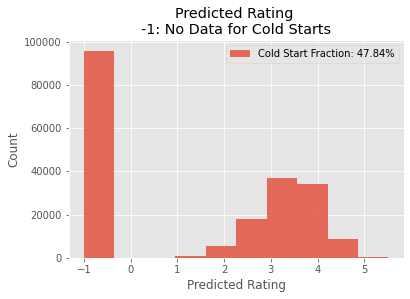

In [79]:
fig, ax = plt.subplots()
ax.hist(test_request['rating'], alpha=0.8, 
        label=f'Cold Start Fraction: {cold_start_fraction*100:.2f}%')
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('Count')
ax.set_title('Predicted Rating \n-1: No Data for Cold Starts')
ax.legend()
plt.savefig('images/cold_start_hist.png', dpi=250)

## Parameter Tuning

In [88]:
# Check training data

ValueError: malformed node or string: [1, 2, 3, 3, 5]